<center> <h1>PREDICIÓN DEL SUEÑO CON SVM</h1> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza seco</h4> </center>


###### Índice de contenidos

En este jupyter notebook se lleva a cabo la construcción de un clasificador SVM tanto de salida binaria como multiclase para predecir tanto el estado de vigilia de los sujetos como el estado de sueño y sus distintas fases.
    
    1. Clasificador SVM Binario
        1.1 Preparación datos de entrada y salida
        1.2 Creación del modelo y selección parámetros libres
        1.3 Búsqueda de parámetros con validación cruzada
        1.4 Evaluación del modelo
        1.5 Visualización de resultados
    2. Clasficador SVM Multiclase
        2.1 Preparación datos de entrada y salida
        2.2 Creación del modelo y selección parámetros libres
        2.3 Búsqueda de parámetros con validación cruzada
        2.4 Evaluación del modelo
        2.5 Visualización de resultados

In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

## 1. SVM BINARIO

En este primer clasificador, se ha utilizado el método SVM para clasificar la vigilia o sueño ligero del sueño profundo. Es decir, se ha construido un clasificador SVM con salida binaria: 0 y 1.

### 1.1 Preparación datos de entrada y salida

In [2]:
Train_bin= pd.read_csv('Train_binary.csv')
Test_bin= pd.read_csv('Test_binary.csv')

In [3]:
X_train_bin=Train_bin.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1) 
y_train_bin=Train_bin['Etiquetas binarias']

X_test_bin=Test_bin.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1)
y_test_bin=Test_bin['Etiquetas binarias']

### 1.2  Creación del modelo y selección parámetros libres

In [4]:
clf = SVC(kernel='linear', gamma=1,decision_function_shape='ovr' ) # gamma=1 o C=10, depende del que queramos fijar
modelo_base=clf.fit(X_train_bin,y_train_bin)

In [5]:
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 1.3  Búsqueda de parámetros con validación cruzada

A continuación, se realiza la búsqueda de parámetros. El parámetro gamma o C se fija y se hace un 'barrido' de los posibles valores del parámetro no fijado para elegir aquel que maximice la exactitud (accuracy).

Tras varias iteraciones se ha visto que los mejores parámetros son gamma=1 y C=10 para el clasificadro binario.

In [6]:
Cs =[0.1,1,10,100,1000] # gamma = range(1,10,1) si se quisiese estimar gamma
param_grid = { 'C': Cs  } #'gamma': gamma
svc_grid = GridSearchCV(clf, param_grid, scoring='accuracy',cv=5,n_jobs=-1)
svc_grid.fit(X_train_bin, y_train_bin)
best_param=svc_grid.best_params_

In [7]:
# Clasificador con los mejores parámetros
svc_clf=svc_grid.best_estimator_

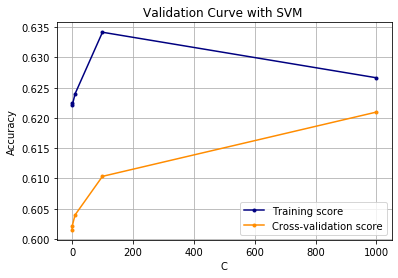

In [8]:
train_scores, test_scores = validation_curve(svc_clf, X_train_bin, y_train_bin, param_name="C", param_range=Cs,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with SVM ")
plt.xlabel('C')
plt.ylabel("Accuracy")

plt.plot(Cs, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(Cs, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

In [9]:
print("El valor más óptimo para el parámetro a estimar es:",best_param)

El valor más óptimo para el parámetro a estimar es: {'C': 1000}


In [10]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test_bin,y_test_bin))
print("Tasa de acierto con la busqueda de parámetros:",svc_clf.score(X_test_bin,y_test_bin))
print('Mejora  del {:0.2f}%.'.format( 100 * (svc_clf.score(X_test_bin,y_test_bin) - modelo_base.score(X_test_bin,y_test_bin)) / modelo_base.score(X_test_bin,y_test_bin)))

Tasa de acierto del modelo base: 0.6048502139800286
Tasa de acierto con la busqueda de parámetros: 0.6162624821683309
Mejora  del 1.89%.


### 1.4 Evaluación del modelo

In [11]:
predict = svc_clf.predict(X_test_bin)

acc_test= svc_clf.score(X_test_bin, y_test_bin).round(4)
acc_train= svc_clf.score(X_train_bin, y_train_bin).round(4)
print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print("=============== Classification Report ================")
print(classification_report(y_test_bin, predict))

La exactitud para el modelo de SVM en el conjunto de TEST es: 0.6163 

La exactitud para el modelo de SVM en el conjunto de TRAIN es: 0.6298 

=============== Classification Report ================
              precision    recall  f1-score   support

         0.0       0.65      0.45      0.53       337
         1.0       0.60      0.77      0.68       364

    accuracy                           0.62       701
   macro avg       0.62      0.61      0.60       701
weighted avg       0.62      0.62      0.61       701



In [12]:
matriz_confusion=pd.crosstab(y_test_bin,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])
matriz_confusion

Resultado del clasificador,0.0,1.0
Clase predicha,,
0.0,150,187
1.0,82,282


### 1.5 Visualización de resultados
A continuación se muestra un ejemplo de predicción con las 30 primeras muestras:

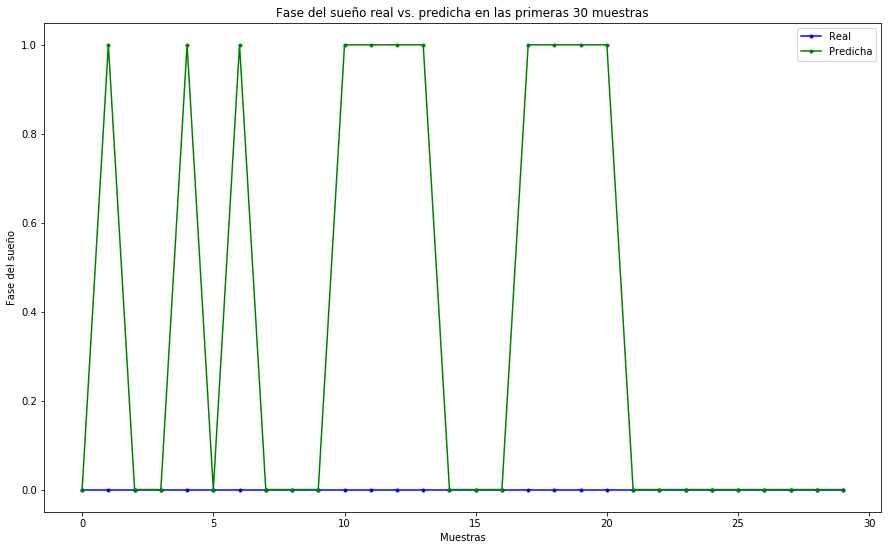

In [13]:
sujetos = len(y_test_bin[0:30])
t = np.arange(0,sujetos)
plt.figure(figsize=(15,9))
plt.plot(t,y_test_bin[0:30],color='blue', marker='.',label='Real')
plt.plot(t,predict[0:30],color='green', marker='.',label='Predicha')

plt.title('Fase del sueño real vs. predicha en las primeras 30 muestras')
plt.xlabel('Muestras')
plt.ylabel('Fase del sueño')
plt.legend()

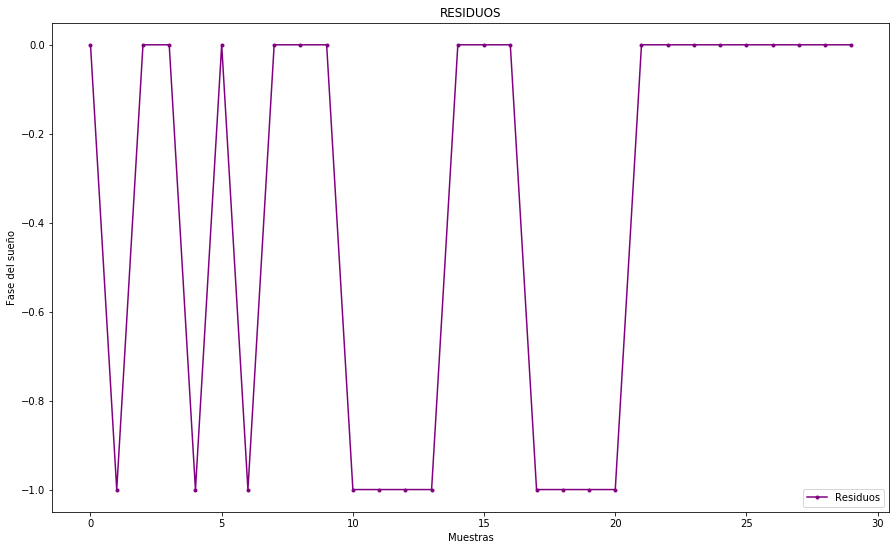

In [14]:
sujetos = len(y_test_bin[0:30])
t = np.arange(0,sujetos)
plt.figure(figsize=(15,9))
plt.plot(t,y_test_bin[0:30]-predict[0:30],color='purple', marker='.',label='Residuos')

plt.title('RESIDUOS')
plt.xlabel('Muestras')
plt.ylabel('Fase del sueño')
plt.legend()

## 2. SVM MULTICLASE

Este segundo clasificador SVM tiene una salida multiclase y clasifica tanto el estado de vigilia como las distintas etapas de sueño ligero y profundo: 0,1,2,3,5.

### 2.1 Preparación datos de entrada y salida

In [15]:
Train_multi= pd.read_csv('Train_multiclass.csv')
Test_multi= pd.read_csv('Test_multiclass.csv')

In [16]:
X_train_multi=Train_multi.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1) 
y_train_multi=Train_multi['Etiquetas multiclase']

X_test_multi=Test_multi.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1)
y_test_multi=Test_multi['Etiquetas multiclase']

### 2.2 Creación del modelo y selección parámetros libres

In [17]:
clf = SVC(kernel='linear',gamma=0.1,decision_function_shape='ovr')
modelo_base=clf.fit(X_train_multi,y_train_multi)

### 2.3 Búsqueda de parámetros con validación cruzada

En primer lugar, se fija el valor de gamma y se deja el valor de C por defecto.

In [ ]:
Cs =[0.1,1,10,100,1000]
param_grid = {'C': Cs}
svc_grid = GridSearchCV(clf, param_grid, scoring='accuracy',cv=5,n_jobs=-1)
svc_grid.fit(X_train_multi, y_train_multi)
C=svc_grid.best_params_

In [ ]:
svc_clf=svc_grid.best_estimator_

In [ ]:
train_scores, test_scores = validation_curve(svc_clf, X_train_multi, y_train_multi, param_name="C", param_range=Cs,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with SVM ")
plt.xlabel('C')
plt.ylabel("Accuracy")

plt.plot(Cs, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(Cs, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

In [ ]:
print("C que maximiza la accuracy:",C)

In [ ]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test_multi,y_test_multi))
print("Tasa de acierto con la busqueda de parámetros:",svc_clf.score(X_test_multi,y_test_multi))
print('Mejora  del {:0.2f}%.'.format( 100 * (svc_clf.score(X_test_multi,y_test_multi) - modelo_base.score(X_test_multi,y_test_multi)) / modelo_base.score(X_test_multi,y_test_multi)))

### 2.4 Evaluación del modelo

In [ ]:
predict = svc_clf.predict(X_test_multi)

acc_test= svc_clf.score(X_test_multi, y_test_multi).round(4)
acc_train= svc_clf.score(X_train_multi, y_train_multi).round(4)

print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print("=============== Classification Report ================")
print(classification_report(y_test_multi, predict))

In [ ]:
matriz_confusion=pd.crosstab(y_test_multi,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])
matriz_confusion

### 2.5 Visualización de resultados

In [ ]:
sujetos = len(y_test_multi)
t = np.arange(0,sujetos)
plt.figure(figsize=(15,9))
plt.plot(t,y_test_multi,color='blue', marker='.',label='Real')
plt.plot(t,predict,color='green', marker='.',label='Predicha')

plt.title('Fase del sueño real vs. predicha en los primeros 30s')
plt.xlabel('Muestras')
plt.ylabel('Fase del sueño')
plt.legend()

**Residuos**

In [ ]:
sujetos = len(y_test_multi)
t = np.arange(0,sujetos)
plt.figure(figsize=(15,9))
plt.plot(t,y_test_multi-predict,color='purple', marker='.',label='Residuos')

plt.title('RESIDUOS')
plt.xlabel('Muestras')
plt.ylabel('Fase del sueño')
plt.legend()

* Estimamos parámetro por parámetro porque hacer los dos a la vez tarda mucho
* No se por qué pero al poner kernel='rbf' se hace todo rapidisimo pero solo reconoce una clase (no lo hace nada bien pero va rapido).
* No se detectan todas las clases en el multiclase --> necesitamos entrenar con mas datos y luego probar a estimar un parámetro y el otro como en el binario
* Baja accuracy en multiclase